In [25]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set the main data path and list categories (subfolders in the dataset directory)
main_path = 'E:\MaxGen\git2025\MPDD\MonkeyPox-Disease-Prediction-System\Monkeypox Skin Image Dataset'
categories = sorted(os.listdir(main_path))  # Sort for consistency
NUM_CLASSES = len(categories)             # Number of distinct categories
IMAGE_SIZE = (224, 224)                  # Image dimensions for ResNet50


In [26]:
# Initialize lists to hold data
X = []
y = []

# Loop over categories and images
for idx, category in enumerate(categories):
    category_path = os.path.join(main_path, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        # Load image (as BGR) and resize
        img = cv2.imread(img_path)
        if img is None:
            continue  # Skip unreadable files
        img = cv2.resize(img, IMAGE_SIZE)
        # Preprocess for ResNet50 (expects BGR, subtracts ImageNet mean, etc.)
        img = preprocess_input(img)
        X.append(img)
        y.append(idx)

# Convert lists to NumPy arrays
X = np.array(X, dtype=np.float32)
y = np.array(y)  # labels as integer class indices

# One-hot encode labels
y = to_categorical(y, num_classes=NUM_CLASSES)

print(f"Total samples: {X.shape[0]}")
print(f"Image data shape: {X.shape[1:]}, Labels shape: {y.shape[1:]}")


Total samples: 364
Image data shape: (224, 224, 3), Labels shape: (4,)


In [27]:
# First, split out validation set (10% of total data)
X_train_full, X_val, y_train_full, y_val = train_test_split(
    X, y, test_size=0.10, random_state=42, shuffle=True
)

# Then, split the remaining 90% into train and test sets (test ~ 22% of original data)
X_train, X_test, y_train, y_test = train_test_split(
    X_train_full, y_train_full, test_size=0.22/0.90, random_state=42, shuffle=True
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Training set: 247 samples
Validation set: 37 samples
Test set: 80 samples


In [28]:
import cv2

def save_images(X, y, split_name, class_names):
    for idx, (img, label) in enumerate(zip(X, y)):
        class_name = class_names[np.argmax(label)]
        save_dir = f"output2/{split_name}/{class_name}"
        os.makedirs(save_dir, exist_ok=True)

        img_uint8 = (img * 255).astype("uint8")
        cv2.imwrite(f"{save_dir}/{idx}.jpg", img_uint8)

class_names = categories  # or train_gen.class_indices.keys()

save_images(X_train, y_train, "train", class_names)
save_images(X_val, y_val, "val", class_names)
save_images(X_test, y_test, "test", class_names)

print("✅ Images saved in output2/")


✅ Images saved in output2/


In [29]:
# Load pre-trained ResNet50 base (no top, with global average pooling)
base_model = ResNet50(weights='imagenet', include_top=False,
                      pooling='avg', input_shape=(*IMAGE_SIZE, 3))
base_model.trainable = False  # Freeze base model layers

# Build our top model
model = Sequential([
    base_model,
    Dense(NUM_CLASSES, activation='softmax')
])

model.summary()

# Compile the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6,
                                    momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_3 (Dense)             (None, 4)                 8196      
                                                                 
Total params: 23,595,908
Trainable params: 8,196
Non-trainable params: 23,587,712
_________________________________________________________________


In [30]:
# Define callbacks: early stopping and model checkpointing
early_stopper = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)


In [31]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopper, checkpoint]
)


Epoch 1/10
8/8 [==============================] - 20s 2s/step - loss: 1.3101 - accuracy: 0.5142 - val_loss: 1.1615 - val_accuracy: 0.7027
Epoch 2/10
8/8 [==============================] - 14s 2s/step - loss: 0.4815 - accuracy: 0.8907 - val_loss: 0.5977 - val_accuracy: 0.8378
Epoch 3/10
8/8 [==============================] - 13s 2s/step - loss: 0.1944 - accuracy: 0.9312 - val_loss: 0.4545 - val_accuracy: 0.8649
Epoch 4/10
8/8 [==============================] - 12s 2s/step - loss: 0.0694 - accuracy: 0.9757 - val_loss: 0.5834 - val_accuracy: 0.8108
Epoch 5/10
8/8 [==============================] - 12s 2s/step - loss: 0.0381 - accuracy: 0.9919 - val_loss: 0.4872 - val_accuracy: 0.8649
Epoch 6/10
8/8 [==============================] - 13s 2s/step - loss: 0.0199 - accuracy: 1.0000 - val_loss: 0.5103 - val_accuracy: 0.8378


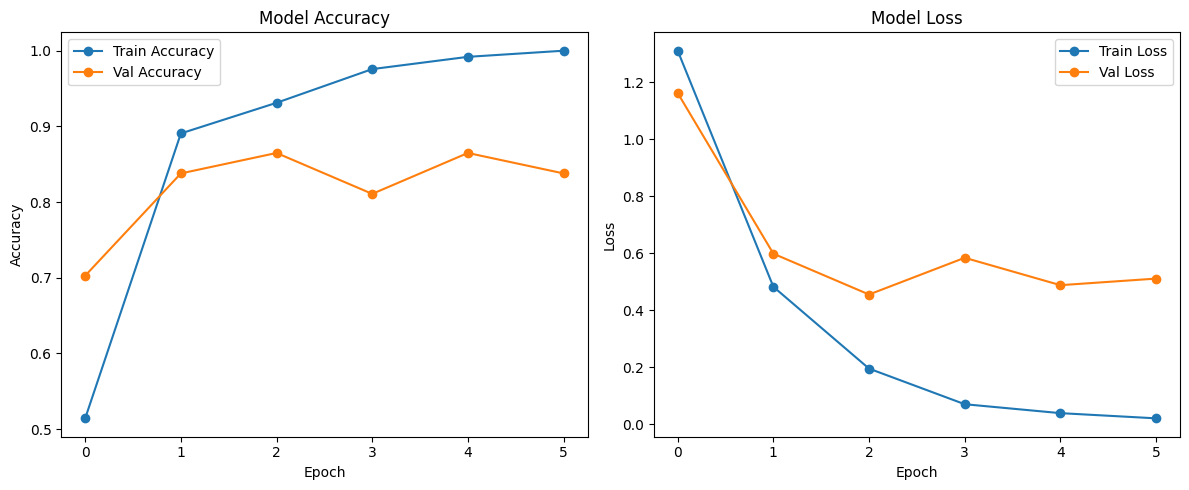

In [32]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [33]:
# Load the best saved model (if not already loaded via EarlyStopping)
model.load_weights('best_model.h5')

# Evaluate on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


Test Accuracy: 82.50%


In [34]:
from keras.models import load_model
model_path = "best_model.h5"
model = load_model(model_path)

In [45]:
class_name = ['Monkeypox', 'Measles', 'Normal', 'Chickenpox']

In [48]:
def predict_image_from_path(image_path, model, class_names):
    # Read image (BGR)
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("❌ Image path wrong aahe")

    # Resize
    img = cv2.resize(img, (224, 224))

    # For display: convert BGR -> RGB
    img_display = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Preprocess using ResNet50 preprocessing (must match training)
    img_proc = img.astype(np.float32)
    img_proc = np.expand_dims(preprocess_input(img_proc), axis=0)

    # Predict
    preds = model.predict(img_proc, verbose=0)
    pred_index = np.argmax(preds)
    confidence = preds[0][pred_index] * 100

    # Show image
    plt.imshow(img_display)
    plt.axis("off")
    plt.title(
        f"Predicted: {class_names[pred_index]}\nAccuracy: {confidence:.2f}%",
        fontsize=12
    )
    plt.show()

    # Print probabilities
    print("📊 Class-wise confidence:")
    for cls, prob in zip(class_names, preds[0]):
        print(f"{cls:15s}: {prob*100:.2f}%")


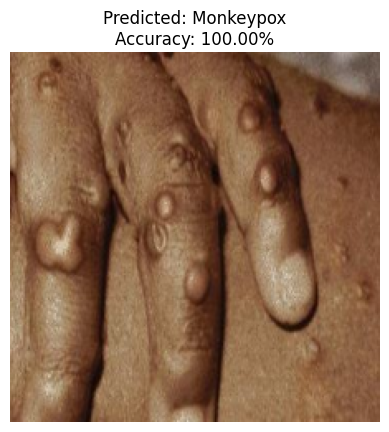

📊 Class-wise confidence:
Chickenpox     : 0.00%
Measles        : 0.00%
Monkeypox      : 100.00%
Normal         : 0.00%


In [49]:
image_path = "E:\\MaxGen\\Deep Learning\\MPDD\\Monkeypox Skin Image Dataset\\Monkeypox\\monkeypox5.png"
predict_image_from_path(image_path, model, class_names)


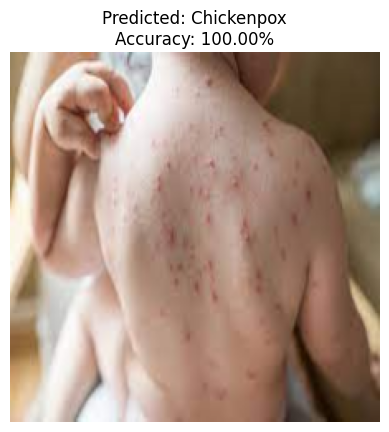

📊 Class-wise confidence:
Chickenpox     : 100.00%
Measles        : 0.00%
Monkeypox      : 0.00%
Normal         : 0.00%


In [51]:
image_path = "E:\MaxGen\git2025\MPDD\MonkeyPox-Disease-Prediction-System\Monkeypox Skin Image Dataset\Chickenpox\chickenpox1.png"
predict_image_from_path(image_path, model, class_names)


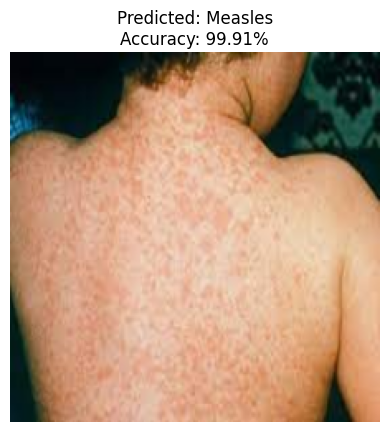

📊 Class-wise confidence:
Chickenpox     : 0.00%
Measles        : 99.91%
Monkeypox      : 0.08%
Normal         : 0.00%


In [53]:
image_path = "E:\MaxGen\git2025\MPDD\MonkeyPox-Disease-Prediction-System\Monkeypox Skin Image Dataset\Measles\measles1.png"
predict_image_from_path(image_path, model, class_names)

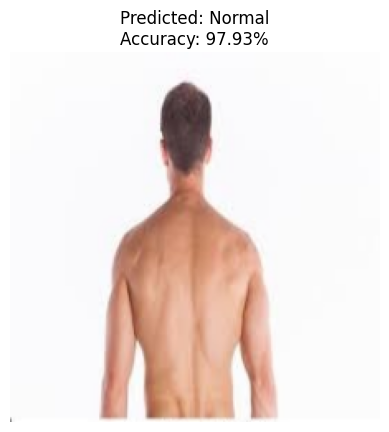

📊 Class-wise confidence:
Chickenpox     : 0.36%
Measles        : 1.71%
Monkeypox      : 0.00%
Normal         : 97.93%


In [63]:
image_path = "Monkeypox Skin Image Dataset\\Normal\\normal9.png"
predict_image_from_path(image_path, model, class_names)